# Gold Classification Model

This model is going to predict the probability of an increase of the weekly average gold price.

## Data

The data will be downloaded with the **Quandl** R package.

## Features

The features of the model are going to be:
 - Gold price lags
 - Gold price mobile averages
 - Gold price performance
 - Gold price performance lags
 - Increase gold price streaks
 - Increase gold price streaks lags
 - Month

# Libraries

In [1]:
library(dplyr)
library(ggplot2)
library(readr)
library(forcats)
library(repr)
library(mltools)
library(data.table)
library(rvest)
library(stringi)
library(zoo)
library(PMwR)
library(Quandl)
library(h2o)

Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”Warning message:
“package ‘forcats’ was built under R version 3.5.2”Warning message:
“package ‘repr’ was built under R version 3.5.2”Warning message:
“package ‘data.table’ was built under R version 3.5.2”
Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
“package ‘rvest’ was built under R version 3.5.2”Loading required package: xml2

Attaching package: ‘rvest’

The following object is masked from ‘package:readr’:

    guess_encoding

Warning message:
“package ‘stringi’ was built under R version 3.5.2”Warning message:
“package ‘zoo’ was built under R version 3.5.2”
Attaching packa

# Reading Data

Reading historic gold price

In [2]:
gold_price <- Quandl("WGC/GOLD_DAILY_USD", api_key="xCLj7WmfLsvdi9xo2okv")
names(gold_price) <- c('date', 'goldprice')

## Recent Data

Data from 2005 to now

In [3]:
gold_price %>%
 filter(date >= as.Date('2005-01-01')) -> gold_price

# Weekly transformation

Create:
 - weekly average gold price
 - month

In [4]:
gold_price %>%
 mutate(week = paste0(format(date, '%Y'),'-',format(date, '%W'))) %>%
 group_by(week) %>%
 summarise(min_date = min(date),
           max_date = max(date),
           avg_gold = mean(goldprice, na.rm = TRUE)) %>%
 arrange(as.numeric(gsub('-','',week))) %>%
 mutate(mes = format(max_date, '%m')) %>%
 mutate(mes = ifelse(mes == '01', 'Ene', mes),
        mes = ifelse(mes == '02', 'Feb', mes),
        mes = ifelse(mes == '03', 'Mar', mes),
        mes = ifelse(mes == '04', 'Abr', mes),
        mes = ifelse(mes == '05', 'May', mes),
        mes = ifelse(mes == '06', 'Jun', mes),
        mes = ifelse(mes == '07', 'Jul', mes),
        mes = ifelse(mes == '08', 'Ago', mes),
        mes = ifelse(mes == '09', 'Sep', mes),
        mes = ifelse(mes == '10', 'Oct', mes),
        mes = ifelse(mes == '11', 'Nov', mes),
        mes = ifelse(mes == '12', 'Dic', mes)) %>%
 mutate(month = as.factor(mes)) %>%
 select(-mes) -> data

In [5]:
head(data)

week    min_date   max_date   avg_gold month
1 2005-01 2005-01-03 2005-01-07 427.18   Ene  
2 2005-02 2005-01-10 2005-01-14 422.81   Ene  
3 2005-03 2005-01-17 2005-01-21 423.03   Ene  
4 2005-04 2005-01-24 2005-01-28 425.79   Ene  
5 2005-05 2005-01-31 2005-02-04 419.41   Feb  
6 2005-06 2005-02-07 2005-02-11 414.20   Feb

# Data engineering

Create:
 - Increase gold price indicator
 - Lags
 - Performance
 - Increace price streaks
 - Mobile averages

## Functions

Functions that creates the new features

### Performance

This function will add a column to a data frame with the performance of a given feature.

$$Performance_i = \ln{\frac{Feature_{t+1}}{Feature_{t}}}$$

In [6]:
rend_func <- function(df, col_ref, nom_col_nueva){
    
    df %>%
      mutate_(aux1 = col_ref) %>%
     # mutate(aux2  = aux1) %>%
      mutate(aux3  = log(aux1/lag(aux1))) %>%
      select(-aux1) -> d
    
  names(d)[which(names(d) == 'aux3')] <- nom_col_nueva
  
  return(d)
}

### Lags

This function will add a new feature with a *n* time _lag_ to a data frame.

$$FeatureLagn_{t} = Feature_{t-n} $$

Where _n_ is the number of weeks of the lag

In [7]:
rez_func <- function(df, col_ref, nom_col_nueva, num_rezagos){
    
    # Se crea vector con código de número de lags a hacer y sus paréntesis de cierre para train
    num_lags  <- rep('lag(',num_rezagos-1)
    close_par <- rep(')', num_rezagos-1)
  
  # Se convierten a un sólo caracter
  num_lags  <- stri_paste(num_lags, collapse = '')
  close_par <- stri_paste(close_par, collapse = '')
  
  # Se pega el código
  cod <- paste0(num_lags, 'aux', close_par)
  
  # Se crea la columna nueva
  df %>%
    mutate_(aux = col_ref) %>%
    mutate_(aux = cod) -> d
  
  names(d)[which(names(d) == 'aux')] <- nom_col_nueva
  
  return(d)
}

### Movile Averages

Function that add to a _data frame_ a feature with de **movile average** of _n_ weeks for a given feature.

$$FeatureMovileAverage_i = \frac{1}{n}\sum_{i=1}^{n} Feature_{t-i}$$

In [8]:
mm_func <- function(df, col_ref, nom_col_nueva, t, ind_train){

    # Se crea el vector de medias móviles a "t" tiempos para train
    df %>%
      mutate_(aux = col_ref) %>%
      mutate(aux = aux) %>%
      select(aux) %>%
      pull() %>%
      rollmean(x = ., k = t) -> mm
  
  # Para poder agregar la columna, se deben agregar NA's al principio para que coincida el número de columnas
  mm <- c(rep(NA,t-1), mm)
  
  # Se agrega el vector de medias móviles al df
  df %>%
    mutate(aux = mm) -> d
  
  names(d)[which(names(d) == 'aux')] <- nom_col_nueva
  
  return(d)
}

### Streaks

Function that add to a _data frame_ a feature defined as: the number of consecutive increasing weeks of a given feature.

In [9]:
racha <- function(df, col_ref, nom_col_nueva, ind_train){

      df %>%
       mutate_(aux1 = col_ref) %>%
       mutate(aux2  = aux1) %>%
       mutate(aux3  = aux1-lag(aux2)) %>%
       mutate(ind = ifelse(aux3 <= 0, FALSE, TRUE)) %>%
       group_by(grp = rleid(ind)) %>%
       mutate(n = rank(min_date)) %>%
       mutate(n = ifelse(ind == FALSE, 0, n)) %>%
       data.frame() %>%
       mutate(racha = lag(n)) %>%
       select(-aux1, -aux2, -aux3, -n, -grp, -ind) -> d 

    names(d)[which(names(d) == 'racha')] <- nom_col_nueva
    
    return(d)
    
}

## Create Features

With the functions created, add the new features to the data

### Performance

In [10]:
data <- rend_func(data, 'avg_gold', 'rend_price')

Warning message:
“mutate_() is deprecated. 
Please use mutate() instead

The 'programming' vignette or the tidyeval book can help you
to program with mutate() : https://tidyeval.tidyverse.org
This warning is displayed once per session.”

### Lags

In [11]:
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_1s',  1)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_2s',  2)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_3s',  3)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_4s',  4)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_6s',  6)
data <- rez_func(data, 'avg_gold', 'rez_avg_gold_8s',  8)

In [12]:
data <- rez_func(data, 'rend_price', 'rez_rend_gold_1s',  1)
data <- rez_func(data, 'rend_price', 'rez_rend_gold_2s',  2)
data <- rez_func(data, 'rend_price', 'rez_rend_gold_3s',  3)
data <- rez_func(data, 'rend_price', 'rez_rend_gold_4s',  4)
data <- rez_func(data, 'rend_price', 'rez_rend_gold_6s',  6)
data <- rez_func(data, 'rend_price', 'rez_rend_gold_8s',  8)

### Streaks

In [13]:
data <- racha(data, 'avg_gold',        'streak_gold')
data <- racha(data, 'rez_avg_gold_1s', 'streak_gold_rez1d')
data <- racha(data, 'rend_price',      'streak_rend_price')

### Moviles Averages

In [14]:
data <- mm_func(data, 'avg_gold', 'mm2_avg_gold', 2)
data <- mm_func(data, 'avg_gold', 'mm3_avg_gold', 3)
data <- mm_func(data, 'avg_gold', 'mm4_avg_gold', 4)

data <- mm_func(data, 'rend_price', 'mm2_rend', 2)
data <- mm_func(data, 'rend_price', 'mm3_rend', 3)
data <- mm_func(data, 'rend_price', 'mm4_rend', 4)

## Increase Gold Price Indicator

$$Ind_t = \begin{cases} 1 & \text{if } GoldPrice_{t+1} > GoldPrice_t \\ 0 & \text{otherwise} \end{cases}$$

In [15]:
data %>%
 mutate(ind = ifelse(avg_gold > lag(avg_gold), 1, 0)) %>%
 mutate(ind = lead(ind)) %>%
 mutate(ind = as.factor(ind)) -> data

In [16]:
head(data)

week    min_date   max_date   avg_gold month rend_price   rez_avg_gold_1s
1 2005-01 2005-01-03 2005-01-07 427.18   Ene             NA 427.18         
2 2005-02 2005-01-10 2005-01-14 422.81   Ene   -0.010282565 422.81         
3 2005-03 2005-01-17 2005-01-21 423.03   Ene    0.000520193 423.03         
4 2005-04 2005-01-24 2005-01-28 425.79   Ene    0.006503168 425.79         
5 2005-05 2005-01-31 2005-02-04 419.41   Feb   -0.015097305 419.41         
6 2005-06 2005-02-07 2005-02-11 414.20   Feb   -0.012500013 414.20         
  rez_avg_gold_2s rez_avg_gold_3s rez_avg_gold_4s ⋯ streak_gold
1     NA              NA              NA          ⋯ NA         
2 427.18              NA              NA          ⋯ NA         
3 422.81          427.18              NA          ⋯  0         
4 423.03          422.81          427.18          ⋯  1         
5 425.79          423.03          422.81          ⋯  2         
6 419.41          425.79          423.03          ⋯  0         
  streak_gold_rez1d streak_rend_price mm2_avg_gold mm3_avg_gold mm4_avg_gold
1 NA                NA                     NA            NA           NA    
2 NA                NA                424.995            NA           NA    
3  0                NA                422.920      424.3400           NA    
4  1                 1                424.410      423.8767     424.7025    
5  2                 2                422.600      422.7433     422.7600    
6  0                 0                416.805      419.8000     420.6075    
  mm2_rend     mm3_rend     mm4_rend     ind
1           NA           NA           NA 0  
2           NA           NA           NA 1  
3 -0.004881186           NA           NA 1  
4  0.003511681 -0.001086401           NA 0  
5 -0.004297068 -0.002691315 -0.004589127 0  
6 -0.013798659 -0.007031383 -0.005143489 1

## Cleaning NAs

Removing NAs created for lags

In [17]:
data <- data[9:nrow(data),]

# Descriptives

## Historical time series

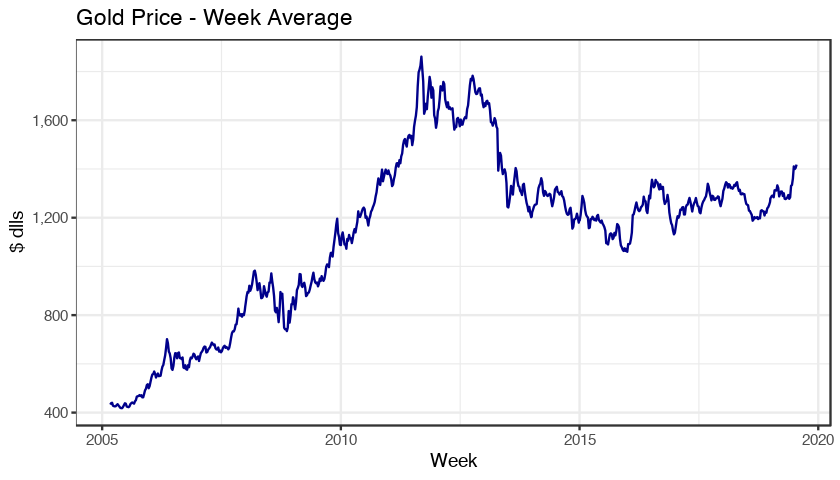

In [18]:
options(repr.plot.width=7, repr.plot.height=4)
data %>%
 ggplot() +
 geom_line(aes(x = max_date, y = avg_gold, group = 1), colour = 'darkblue') +
 theme_bw() +
 ggtitle('Gold Price - Week Average') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 scale_y_continuous(labels = scales::comma) +
 xlab('Week') +
 ylab('$ dlls')

In [19]:
options(repr.plot.width=7, repr.plot.height=4)
data %>%
 filter(max_date >= as.Date('2019-01-01')) %>%
 ggplot() +
 geom_line(aes(x = max_date, y = avg_gold, group = 1), colour = 'darkblue') +
 theme_bw() +
 ggtitle('Gold Price - Week Average') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 scale_y_continuous(labels = scales::comma) +
 xlab('Week') +
 ylab('$ dlls') -> hist_2019

## Lags Gold Price Correlations

Using feature as id variables


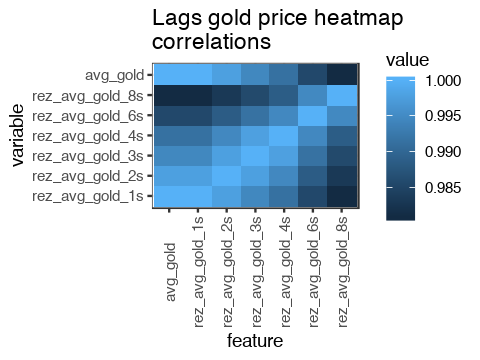

In [20]:
options(repr.plot.width=4, repr.plot.height=3)
data %>%
  select(c(grep('rez_avg', names(data)),'avg_gold')) %>%
  cor() %>%
  data.frame() %>%
  mutate(feature = rownames(.)) %>%
  melt() %>%
  ggplot() +
  geom_tile(aes(x = feature, y = variable, fill = value)) + 
  theme_bw() +
  ggtitle('Lags gold price heatmap \ncorrelations') +
  theme(axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5))

## Lags gold price performance correlations

Using feature as id variables


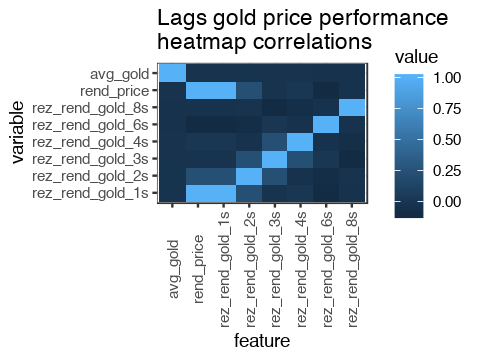

In [21]:
options(repr.plot.width=4, repr.plot.height=3)
data %>%
  select(c(grep('rez_rend', names(data)),'rend_price', 'avg_gold')) %>%
  cor() %>%
  data.frame() %>%
  mutate(feature = rownames(.)) %>%
  melt() %>%
  ggplot() +
  geom_tile(aes(x = feature, y = variable, fill = value)) + 
  theme_bw() +
  ggtitle('Lags gold price performance \nheatmap correlations') +
  theme(axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5))

## Streaks Correlations

Using feature as id variables


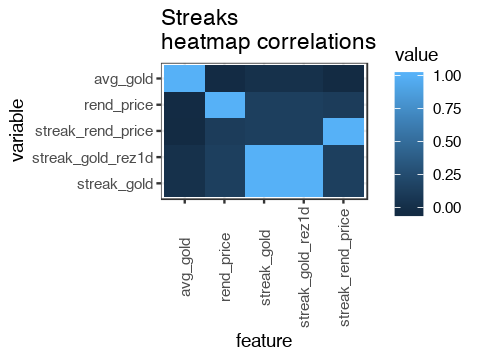

In [22]:
options(repr.plot.width=4, repr.plot.height=3)
data %>%
  select(c(grep('streak', names(data)),'rend_price', 'avg_gold')) %>%
  cor() %>%
  data.frame() %>%
  mutate(feature = rownames(.)) %>%
  melt() %>%
  ggplot() +
  geom_tile(aes(x = feature, y = variable, fill = value)) + 
  theme_bw() +
  ggtitle('Streaks \nheatmap correlations') +
  theme(axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5))

## Moviles Averages Correlations

Using feature as id variables


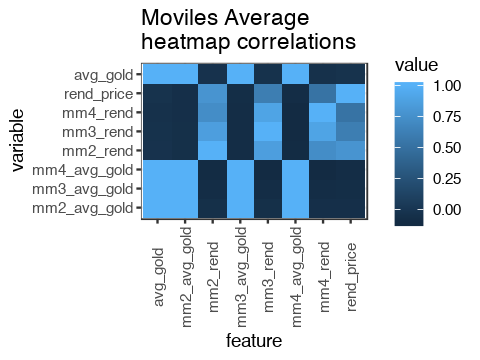

In [23]:
options(repr.plot.width=4, repr.plot.height=3)
data %>%
  select(c(grep('mm', names(data)),'rend_price', 'avg_gold')) %>%
  cor() %>%
  data.frame() %>%
  mutate(feature = rownames(.)) %>%
  melt() %>%
  ggplot() +
  geom_tile(aes(x = feature, y = variable, fill = value)) + 
  theme_bw() +
  ggtitle('Moviles Average \nheatmap correlations') +
  theme(axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5))

# GBM

## Initiate H2O

In [24]:
h2o.init(ip =  "localhost", port = 54321, nthreads = -1, max_mem_size = "14g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T//RtmpbVGBde/h2o_darias_started_from_r.out
    /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T//RtmpbVGBde/h2o_darias_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 104 milliseconds 
    H2O cluster timezone:       America/Mexico_City 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.22.1.1 
    H2O cluster version age:    6 months and 24 days !!! 
    H2O cluster name:           H2O_started_from_R_darias_iaz791 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   14.00 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (6 months and 24 days)!
Please download and install the latest version from http://h2o.ai/download/”

In [25]:
data_h2o <- as.h2o(data %>% filter(!is.na(ind)))

  |======================================================================| 100%


## Split

Split into _train_ and _test_

In [26]:
split <- h2o.splitFrame(data=data_h2o, ratios=0.75, seed = 16)
train <- split[[1]]
test <- split[[2]]

## X & Y

Define features

In [27]:
names(data_h2o)

[1] "week"              "min_date"          "max_date"         
 [4] "avg_gold"          "month"             "rend_price"       
 [7] "rez_avg_gold_1s"   "rez_avg_gold_2s"   "rez_avg_gold_3s"  
[10] "rez_avg_gold_4s"   "rez_avg_gold_6s"   "rez_avg_gold_8s"  
[13] "rez_rend_gold_1s"  "rez_rend_gold_2s"  "rez_rend_gold_3s" 
[16] "rez_rend_gold_4s"  "rez_rend_gold_6s"  "rez_rend_gold_8s" 
[19] "streak_gold"       "streak_gold_rez1d" "streak_rend_price"
[22] "mm2_avg_gold"      "mm3_avg_gold"      "mm4_avg_gold"     
[25] "mm2_rend"          "mm3_rend"          "mm4_rend"         
[28] "ind"

In [28]:
x <- setdiff(names(data), c('week', 'min_date', 'max_date', 'avg_gold', 'ind', 'rend_price', 'streak_gold'))
y <- 'ind'

## Grid

Grid to optimize metaparameters

In [132]:
hyper_params = list(max_depth  = c(1,2,3),
                    learn_rate = c(0.021, 0.023, 0.1),
                    nbins      = c(2,3,5,7),
                    col_sample_rate_per_tree = c(0.2, 0.4, 0.5, 0.6))

## 2019-27
#hyper_params = list(max_depth  = c(2,3,4),
#                    learn_rate = c(0.015, 0.02, 0.023),
#                    nbins      = c(3,5,7),
#                    col_sample_rate_per_tree = c(0.55, 0.60, 0.65))

## 2019-26
#hyper_params = list(max_depth  = c(5,6,7),
#                    learn_rate = c(0.019, 0.02, 0.021),
#                    nbins      = c(136,138,140),
#                    col_sample_rate_per_tree = c(0.45, 0.5, 0.55))


## 2019-25
#hyper_params = list(max_depth  = seq(4,7),
#                    learn_rate = c(0.065, 0.07, 0.075, 0.08),
#                    nbins      = c(30,35,40,45),
#                    col_sample_rate_per_tree = c(0.7, 0.75, 0.8, 0.85))

In [133]:
h2o.rm('grid')
rm(grid)

In [134]:
grid <- h2o.grid(hyper_params         = hyper_params,
                 search_criteria      = list(strategy = "Cartesian"),
                 #grid_id              = 'grid_gbm',
                 algorithm            = "gbm",
                 x                    = x, 
                 y                    = y, 
                 training_frame       = train,
                 ntrees               = 60,                                                            
                 seed                 = 1234,                                                             
                 stopping_rounds      = 20,
                 stopping_tolerance   = 0.0001,
                 stopping_metric      = "AUC",
                 nfolds               = 4,
                 learn_rate_annealing = 0.9999
)

## 2019-27
#grid <- h2o.grid(hyper_params         = hyper_params,
#                 search_criteria      = list(strategy = "Cartesian"),
#                 #grid_id              = 'grid_gbm',
#                 algorithm            = "gbm",
#                 x                    = x, 
#                 y                    = y, 
#                 training_frame       = train,
#                 ntrees               = 50,                                                            
#                 seed                 = 1234,                                                             
#                 stopping_rounds      = 15,
#                 stopping_tolerance   = 0.0001,
#                 stopping_metric      = "AUC",
#                 nfolds               = 3,
#                 learn_rate_annealing = 0.9999
#)

## 2019-26
#grid <- h2o.grid(hyper_params         = hyper_params,
#                 search_criteria      = list(strategy = "Cartesian"),
#                 #grid_id              = 'grid_gbm',
#                 algorithm            = "gbm",
#                 x                    = x, 
#                 y                    = y, 
#                 training_frame       = train,
#                 ntrees               = 50,                                                            
#                 seed                 = 1234,                                                             
#                 #stopping_rounds      = 2,
#                 stopping_rounds      = 15,
#                 stopping_tolerance   = 0.99,
#                 stopping_metric      = "AUC",
#                 nfolds               = 10,
#                 learn_rate_annealing = 0.9999
#)

## 2019-25
#grid <- h2o.grid(hyper_params         = hyper_params,
#                 search_criteria      = list(strategy = "Cartesian"),
#                 #grid_id              = 'grid_gbm',
#                 algorithm            = "gbm",
#                 x                    = x, 
#                 y                    = y, 
#                 training_frame       = train,
#                 ntrees               = 500,                                                            
#                 seed                 = 1234,                                                             
#                 #stopping_rounds      = 2,
#                 stopping_rounds      = 3,
#                 stopping_tolerance   = 0.9,
#                 stopping_metric      = "AUC",
#                 nfolds               = 10,
#                 learn_rate_annealing = 0.99
#)

  |======================================================================| 100%


In [135]:
grid

H2O Grid Details

Grid ID: Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204_208339 
Used hyper parameters: 
  -  col_sample_rate_per_tree 
  -  learn_rate 
  -  max_depth 
  -  nbins 
Number of models: 144 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
  col_sample_rate_per_tree learn_rate max_depth nbins
1                      0.5      0.023         1     3
2                      0.5      0.023         1     2
3                      0.5      0.023         1     5
4                      0.5      0.023         1     7
5                      0.6      0.023         1     2
                                                        model_ids
1  Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204_208339_model_43
2   Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204_208339_model_7
3  Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204_208339_model_79
4 Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204_208339_model_115
5   Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204

## Best Model

In [136]:
best_model <- h2o.getModel(grid@model_ids[[1]])

In [137]:
best_model

Model Details:

H2OBinomialModel: gbm
Model ID:  Grid_GBM_RTMP_sid_8174_3_model_R_1563829651204_208339_model_43 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              60                       60                5025         1
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         1    1.00000          2          2     2.00000


H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.2338155
RMSE:  0.4835447
LogLoss:  0.6603913
Mean Per-Class Error:  0.4112324
AUC:  0.6814212
pr_auc:  0.6945201
Gini:  0.3628425

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        0   1    Error      Rate
0      64 188 0.746032  =188/252
1      24 290 0.076433   =24/314
Totals 88 478 0.374558  =212/566

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.484940 0.732323 111
2                       ma

## AUC

In [138]:
options(repr.plot.width=5, repr.plot.height=4)
data.frame(desc = c('train', 'valid'),
           auc = c(h2o.auc(h2o.performance(best_model,train)) %>% as.numeric,
                    h2o.auc(h2o.performance(best_model,test)) %>% as.numeric)) %>%
 ggplot() +
 geom_bar(aes(x = desc, y = auc), stat = 'identity', fill = 'darkblue') +
 theme_bw() +
 ggtitle('AUC') +
 theme(axis.text.x = element_text(face = 'bold'),
       axis.text.y = element_text(face = 'bold')) +
 geom_text(aes(x = desc, y = auc, label = round(auc,2)), vjust = -0.5, size = 4) -> auc_plot

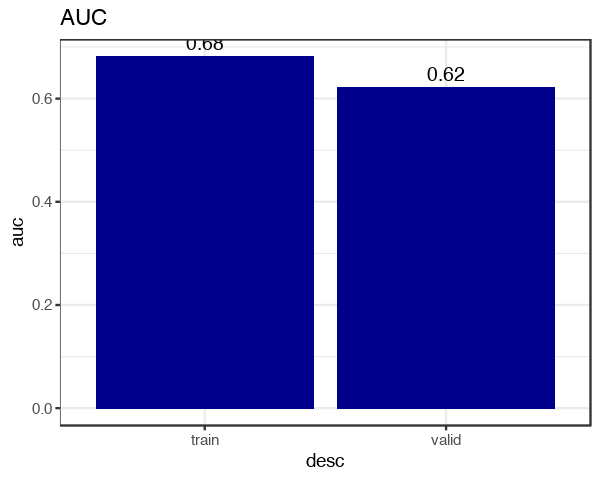

In [139]:
auc_plot

## Variable Importance

In [140]:
h2o.varimp(best_model) %>%
  as.data.frame() %>%
  head(10) %>%
  arrange(scaled_importance) %>%
  mutate(variable = factor(variable, as.character(variable))) %>%
  ggplot() +
  geom_bar(aes(x = variable, y = scaled_importance, fill = scaled_importance), stat = 'identity') +
  theme_bw() +
  ggtitle('Top 10 Varianle Importance') +
  theme(axis.text.x  = element_text(size = 13),
        axis.text.y  = element_text(size = 13),
        axis.title.x = element_text(size = 13),
        axis.title.y = element_text(size = 13),
        legend.position = 'none') +
  coord_flip() -> coef_plot

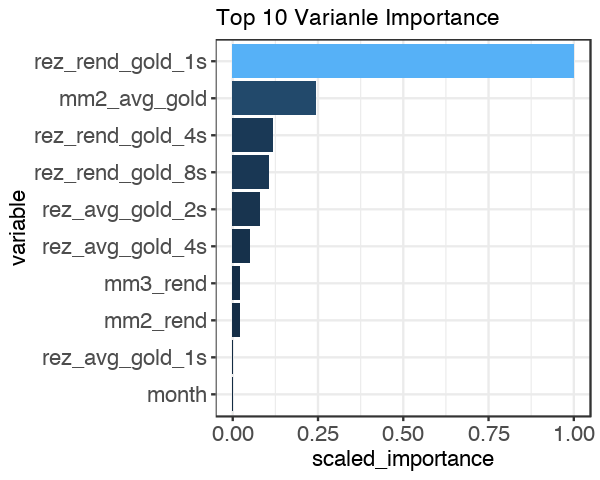

In [141]:
coef_plot

## Partial Plots

In [123]:
pplots <- function(df_valid_h2o, modelo_h2o){
  # Se obtienen los tipos de variables del df de validation
  tipos <- h2o.getTypes(df_valid_h2o) %>% as.data.frame()
  
  # Al dataframe de tipos de variable, se ponen los nombres de las variables
  names(tipos) <- names(df_valid_h2o)
  
  # Se enfila el data frame de tipos
  tipos %>% 
    t(.) %>%
    data.frame() -> tipos
  
  tipos$variable <- rownames(tipos)
  
  names(tipos)[1] <- 'tipo'
  
  # Se extraen los nombres de las 5 variables más importantes
  h2o.varimp(modelo_h2o) %>%
    data.frame() %>%
    head(6) %>%
    dplyr::select(variable) -> top5
  
  # Se le pega el tipo de variable al top5
  top5 %>%
    left_join(., tipos, by = 'variable') -> top5
  
  # Se crea una lista en donde se guardarán las gráficas
  gpplots <- list()
  
  # Se crea un lógico, si las variables son factores o numéricas para hacer de diferente forma las gráficas, con un for para cada variable
  for(i in 1:nrow(top5)){
    if(top5$tipo[i] == 'enum') {
      
      # Se extrae el nombre de la variable i
      var_i <- top5$variable[i]
      
      # Se extrae el df del partial plot de esa variable
      pp_aux <- h2o.partialPlot(modelo_h2o, df_valid_h2o, cols = var_i, plot = FALSE, nbins = 400) %>% data.frame()
      
      # Se pone el nombre de la variable como "variable" para que sea genérico y automatizable
      names(pp_aux)[1] <- 'variable'
      
      # Se hace la gráfica
      pp_aux %>%
        arrange(mean_response) %>%
        mutate(variable = factor(variable, as.character(variable))) %>%
        ggplot() +
        geom_bar(aes(x = variable, y = mean_response), stat = 'identity', fill = 'darkblue') +
        ggtitle(paste0('Marginal Effect \n', var_i)) +
        xlab('') +
        ylab('Mean response') +
        theme_bw() +
        theme(axis.text.x  =  element_text(face = 'bold', size = 10),
              axis.text.y  =  element_text(face = 'bold', size = 16),
              axis.title.x =  element_text(face = 'bold', size = 0),
              axis.title.y =  element_text(face = 'bold', size = 17),
              title        =  element_text(face = 'bold', size = 18)) +
        scale_y_continuous(label = scales::percent) +
        geom_text(aes(x = variable, y = mean_response, label = scales::percent(mean_response)), size = 2, vjust = -0.5) -> gp
      
      # Se guarda en la lista de gráficas
      gpplots[[i]] <- gp
      
    } else {
      
      # Se extrae el nombre de la variable i
      var_i <- top5$variable[i]
      
      # Se extrae el df del partial plot de esa variable
      pp_aux <- h2o.partialPlot(modelo_h2o, df_valid_h2o, cols = var_i, plot = FALSE) %>% data.frame()
      
      # Se pone el nombre de la variable como "variable" para que sea genérico y automatizable
      names(pp_aux)[1] <- 'variable'
      
      # Se hace la gráfica
      pp_aux %>%
        ggplot() +
        geom_line(aes(x = variable, y = mean_response, group = 1), col = 'darkblue') +
        geom_point(aes(x = variable, y = mean_response, group = 1), col = 'darkgreen') +
        ggtitle(paste0('Marginal Effect \n', var_i)) +
        xlab('') +
        ylab('Mean response') +
        theme_bw() +
        scale_y_continuous(label = scales::percent) +
        #scale_x_continuous(label = scales::comma) +
        theme(axis.text.x  =  element_text(face = 'bold', size = 15),
              axis.text.y  =  element_text(face = 'bold', size = 16),
              axis.title.x =  element_text(face = 'bold', size = 0),
              axis.title.y =  element_text(face = 'bold', size = 17),
              title        =  element_text(face = 'bold', size = 18)) -> gp
      
      gpplots[[i]] <- gp
    }
  }
  
  gpplots <<- gpplots
}

In [142]:
pplots(test,best_model)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


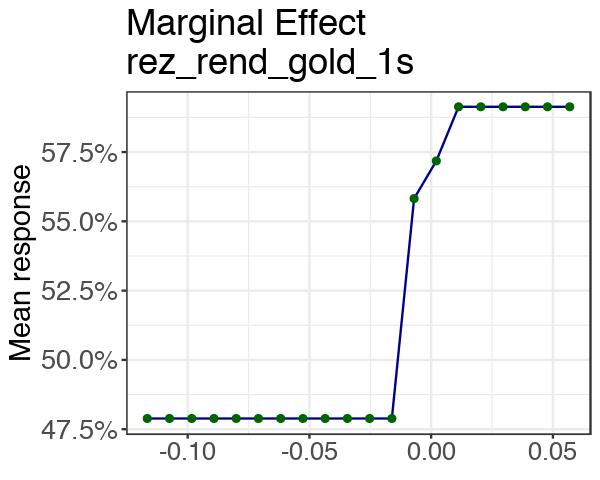

In [143]:
gpplots[[1]]

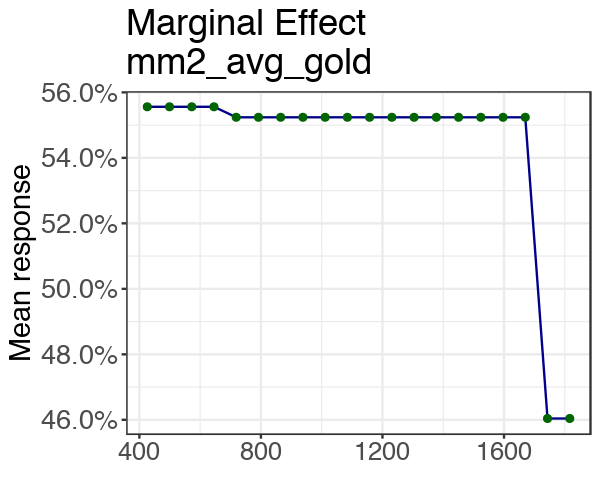

In [144]:
gpplots[[2]]

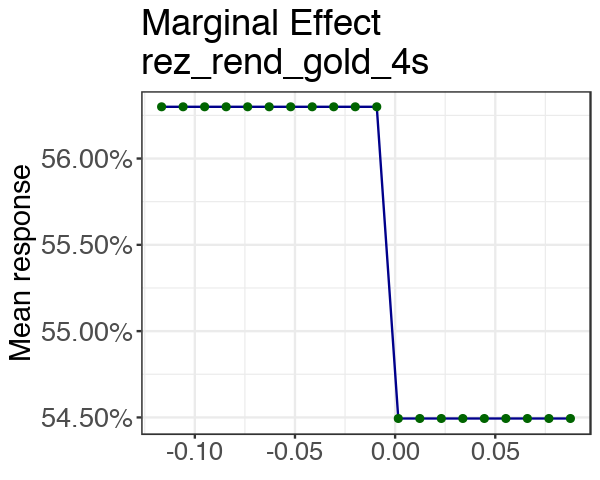

In [145]:
gpplots[[3]]

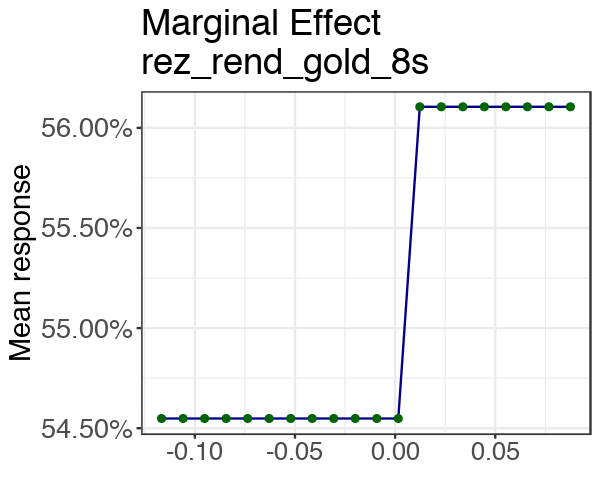

In [146]:
gpplots[[4]]

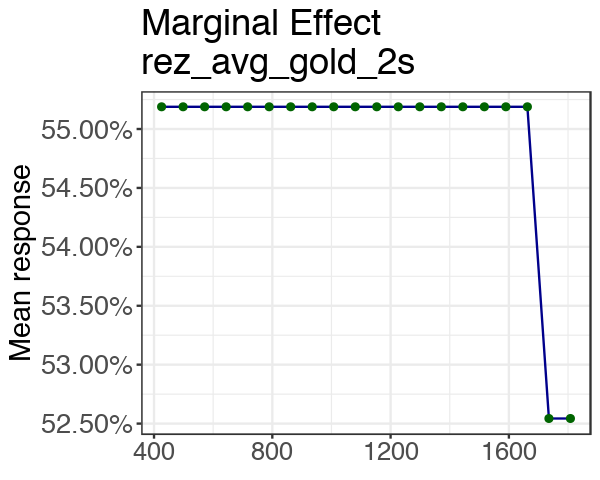

In [147]:
gpplots[[5]]

## Effectiveness

In [148]:
h2o.predict(best_model, test[!is.na(test$ind),]) %>%
 as.data.frame() %>%
 select(p1) %>%
 pull -> pr

test %>%
 as.data.frame() %>%
 filter(!is.na(ind)) %>%
 mutate(ind = as.character(ind)) %>%
 mutate(quans = cut(pr, c(0,quantile(pr, seq(0.2:1, by = 0.2))),
                    include.lowest = TRUE,
                    labels = c('Very Low', 'Low', 'Medium', 'High', 'Very High'))) %>%
# mutate(quans = cut(pr, c(0,quantile(pr, seq(0.2:1, by = 0.2))),
#                    include.lowest = TRUE,
#                    labels = paste0('q', seq(20, 100, by = 20), '%'))) %>%
  group_by(quans) %>%
  summarise(n           = n(),
            num_correct = sum(ind == '1'),
            eff         = num_correct/n) %>%
 ggplot() +
 geom_bar(aes(x = quans, y = eff), stat = 'identity', fill = 'darkblue') +
 theme_bw() +
 ggtitle('Increase Gold Price Probability - Efectiveness') +
 scale_y_continuous(labels = scales::percent) +
 geom_text(aes(x = quans, y = eff, label = scales::percent(eff)), vjust = -0.5) +
 geom_hline(yintercept = mean(test[!is.na(test$ind),'ind']),
            linetype = 'dashed',
            colour = 'darkgreen') +
 annotate(geom  = 'text',
          x     = 2,
          y     = mean(test[!is.na(test$ind),'ind']) + 0.07,
          label = paste0('Average Price Increasing = ',
                         round(mean(test[!is.na(test$ind),'ind'])*100,2),
                         '%'),
          vjust = -0.5,
          size  = 3,
          hjust = 0.7,
          colour = 'darkgreen') +
 xlab('Probability Segmentation') -> ef_plot

  |======================================================================| 100%


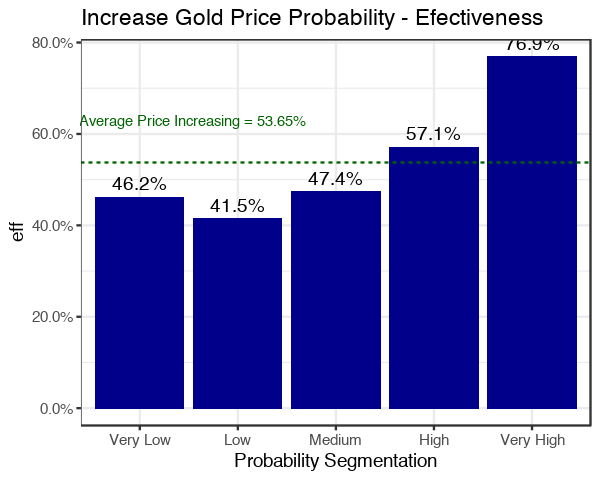

In [149]:
ef_plot

## Next Week Prediction

In [150]:
h2o.predict(best_model, as.h2o(data %>% tail(1))) %>%
 as.data.frame() %>%
 select(p1) %>%
 pull -> week_pred

  |======================================================================| 100%
  |======================================================================| 100%


In [151]:
cut(week_pred, c(0,quantile(pr, seq(0.2:1, by = 0.2))),
                    include.lowest = TRUE,
                    labels = c('Very Low', 'Low', 'Medium', 'High', 'Very High')) -> nw

In [152]:
nw

[1] Medium
Levels: Very Low Low Medium High Very High

# Summary

Report to send in a mail

Calculate the stantard deviation of the gold price for the last week

In [153]:
gold_price %>%
 mutate(week = paste0(format(date, '%Y'),'-',format(date, '%W'))) %>%
 group_by(week) %>%
 summarise(min_date = min(date),
           max_date = max(date),
           std_gold = sd(goldprice, na.rm = TRUE)) -> sd_data

In [154]:
a1 <- paste0('The last week gold price average was $', tail(data$avg_gold,1), 'dlls')
a2 <- paste0('With a volatility (standard deviation) of +/- $', tail(round(sd_data$std_gold,2),1), 'dlls')
a3 <- paste0('The probability of an increase in the gold price average for next week is estimated as: ', toupper(nw))

In [155]:
data.frame(. = c(a1,a2,a3))

.                                                                                             
1 The last week gold price average was $1417.95dlls                                             
2 With a volatility (standard deviation) of +/- $12.52dlls                                      
3 The probability of an increase in the gold price average for next week is estimated as: MEDIUM

# Saving plots

In [156]:
ruta <- '/Users/darias/Documents/GoldPrice/Notebook/Classification_Model/Images'
fecha <- Sys.Date()
ggsave(filename = paste0('auc_', fecha, '.png'), plot = auc_plot, path = ruta, width = 5, height = 4)
ggsave(filename = paste0('historico_week_price_', fecha, '.png'), plot = hist_2019, path = ruta, width = 7, height = 4)
ggsave(filename = paste0('coef_plot_', fecha, '.png'), plot = coef_plot, path = ruta, width = 7, height = 4)
ggsave(filename = paste0('efectividad_', fecha, '.png'), plot = ef_plot, path = ruta, width = 7, height = 4)